# [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

## [Abstract](#abstract)

The Traveling Salesman Problem (TSP) is a **classic problem in [combinatorial optimization](https://en.wikipedia.org/wiki/Combinatorial_optimization)**.

It is the problem of **finding a tour of minimum cost that visits each city exactly once**. The TSP is **NP-hard**. That is, no efficient algorithm is known that finds the optimal solution to the problem for large sets of cities.

## [Exhaustive](#exhaustive-search)
It is a **brute force** algorithm that does not use any information about the problem to find the solution.

- [Heap's Algorithm](#heaps-algorithm)
- [Steinhaus–Johnson–Trotter Algorithm](#sjt-algorithm)

## [Random](#random-search)
Is a **[stochastic optimization](https://en.wikipedia.org/wiki/Stochastic_optimization)** algorithm that does not use any information about the problem to find the solution.

## [Hill Climbing](#hill-climbing-search)
Is a **[local search](https://en.wikipedia.org/wiki/Local_search_(optimization))** algorithm that does not use any information about the problem to find the solution.

----

### Abstract

In this notebook, we're exploring various techniques to solve the [Traveling Salesman Problem (TSP)](https://en.wikipedia.org/wiki/Travelling_salesman_problem).

Our focus is on implementing **exhaustive search**, **random search**, and **hill-climbing algorithms** to tackle this problem. Additionally, **we'll visualize the results of each iteration**, **analyze their performance**, and **draw insightful conclusions**.

By delving into these algorithms and their outcomes, we aim to enhance our understanding of optimization techniques and their practical applications.

In [1]:
import itertools  # for permutations

import numpy as np  # for arrays
import pandas as pd  # for dataframes
import seaborn as sns  # for plotting
import matplotlib.pyplot as plt  # for plotting

# constants for the genetic algorithm
CITIES = 30  # number of cities
GENERATIONS = 100  # number of generations to run
MUTATION_RATE = 0.01  # mutation rate (0.01 = 1%) 1/100

In these part I've define some functions to help us to manage all the algorithms and to visualize the results.

In [2]:
def generate_cities(cities: int) -> np.ndarray:
    """Generate cities with random x and y coordinates."""
    return np.random.rand(cities, 2)

generate_circle = lambda n: np.array([[np.cos(2 * np.pi * i / n), np.sin(2 * np.pi * i / n)] for i in range(n)])

def get_distance_between_cities(city1: np.ndarray, city2: np.ndarray) -> float:
    """Get distance between two cities."""
    return np.sqrt((city1[0] - city2[0]) ** 2 + (city1[1] - city2[1]) ** 2)

def print_distances(cities: np.ndarray, solution: np.ndarray) -> None:
    """Print distances between cities according to the order in the solution."""
    distances = [get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(len(cities) - 1)]
    print(f"Solution:  {solution}\nDistance: {sum(distances)}")  # print solution and total distance
    [print(f"{solution[i-1]} -> {solution[i]}: {distances[i]}") for i in range(len(cities) - 1)]  # print distances between cities

def plot_solution(title: str, cities: np.ndarray, solution: np.ndarray) -> None:
    """Plot solution."""
    plt.figure(figsize=(12, 12))
    [plt.plot([cities[solution[i]][0], cities[solution[i + 1]][0]], [cities[solution[i]][1], cities[solution[i + 1]][1]], c='blue') for i in range(len(cities) - 1)]
    # plt.plot([cities[solution[-1]][0], cities[solution[0]][0]], [cities[solution[-1]][1], cities[solution[0]][1]], c='blue')  # plot a line between the last and the first city
    plt.scatter(cities[:, 0], cities[:, 1], c='blue', s=100)
    plt.title(title)
    plt.show()

def get_fitness(cities: np.ndarray, solution) -> float:
    """
    Get fitness of a solution.
    In most cases, fitness is the inverse of the total distance.
    In this case we will use the total distance as fitness. This because we want to minimize the distance.    
    """
    # distances = [get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(CITIES - 1)]
    # return sum(distances)  # return fitness
    return sum([get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(len(cities) - 1)])

def plot_fitness(title: str, fitness: list) -> None:
    """Plot fitness."""
    plt.plot(fitness)
    plt.title(title)
    plt.show()

def crossover(parents: np.ndarray) -> np.ndarray:
    """Crossover parents to produce offspring."""
    return np.concatenate((parents[0][:CITIES // 2], [city for city in parents[1] if city not in parents[0][:CITIES // 2]]))

def mutate(offspring: np.ndarray) -> np.ndarray:
    """
    Mutate offspring.
    Shuffle offspring (mutation) if mutation rate is reached.
    """
    if np.random.rand() < MUTATION_RATE:  # if mutation rate is reached
        offspring = np.random.permutation(offspring)  # shuffle offspring (mutation)
    return offspring  # return offspring


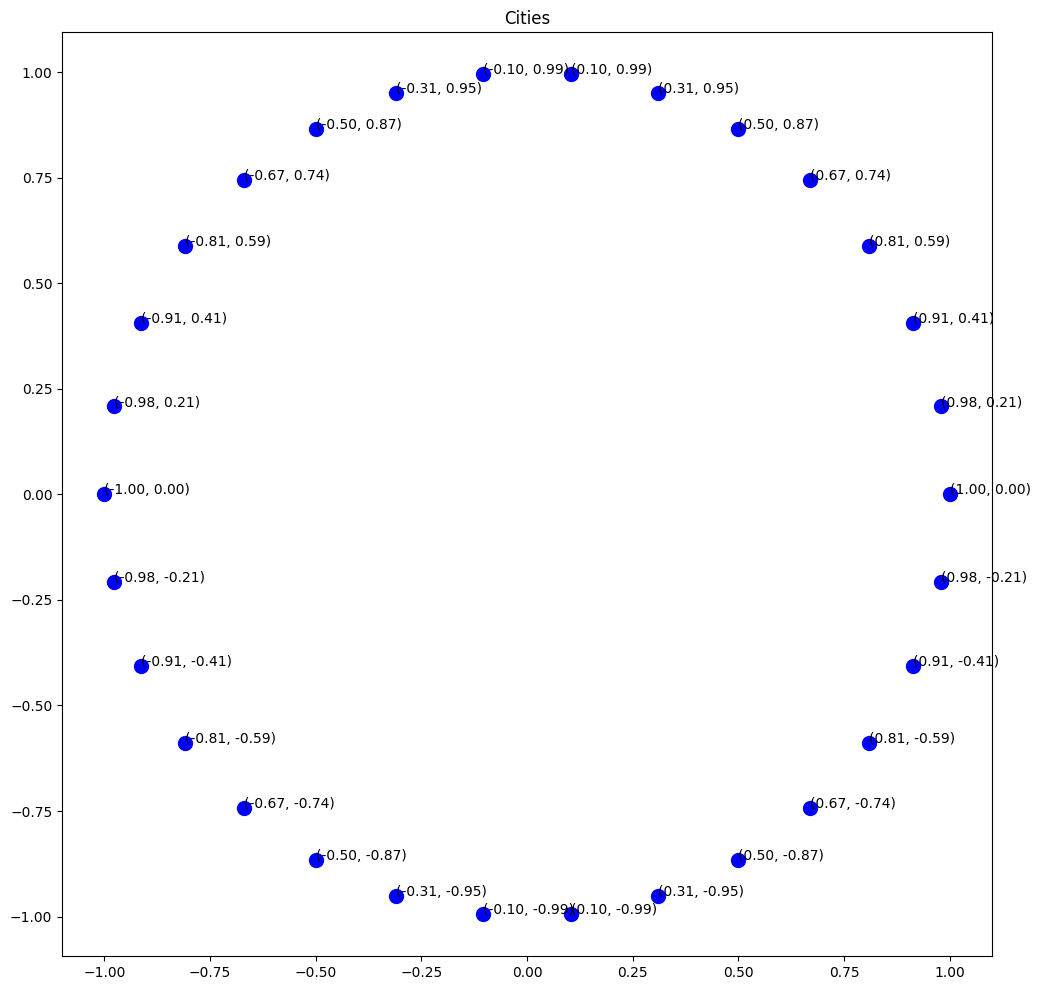

In [3]:
# cities = generate_cities(CITIES)  # generate cities in random positions
cities = generate_circle(CITIES)  # generate cities on the circumference of a circle
# print(cities)

# draw the circle
plt.figure(figsize=(12, 12))
# plt.plot(np.cos(2 * np.pi * np.linspace(0, 1, 100)), np.sin(2 * np.pi * np.linspace(0, 1, 100)), c='gray')  # draw the circle
plt.scatter(cities[:, 0], cities[:, 1], c='blue', s=100)  # draw the cities
[plt.annotate(f"({city[0]:.2f}, {city[1]:.2f})", (city[0], city[1]), fontsize=10) for _, city in enumerate(cities)]  # add the coordinates to the cities
plt.title("Cities")
plt.show()

Here we can see the distribution of the cities in the map.
The cities are distributed along the circumference of a circle with a radius 1.
This means that every city is at a distance of 1 from the center of the circle and the distance between the nearest two cities is the same.

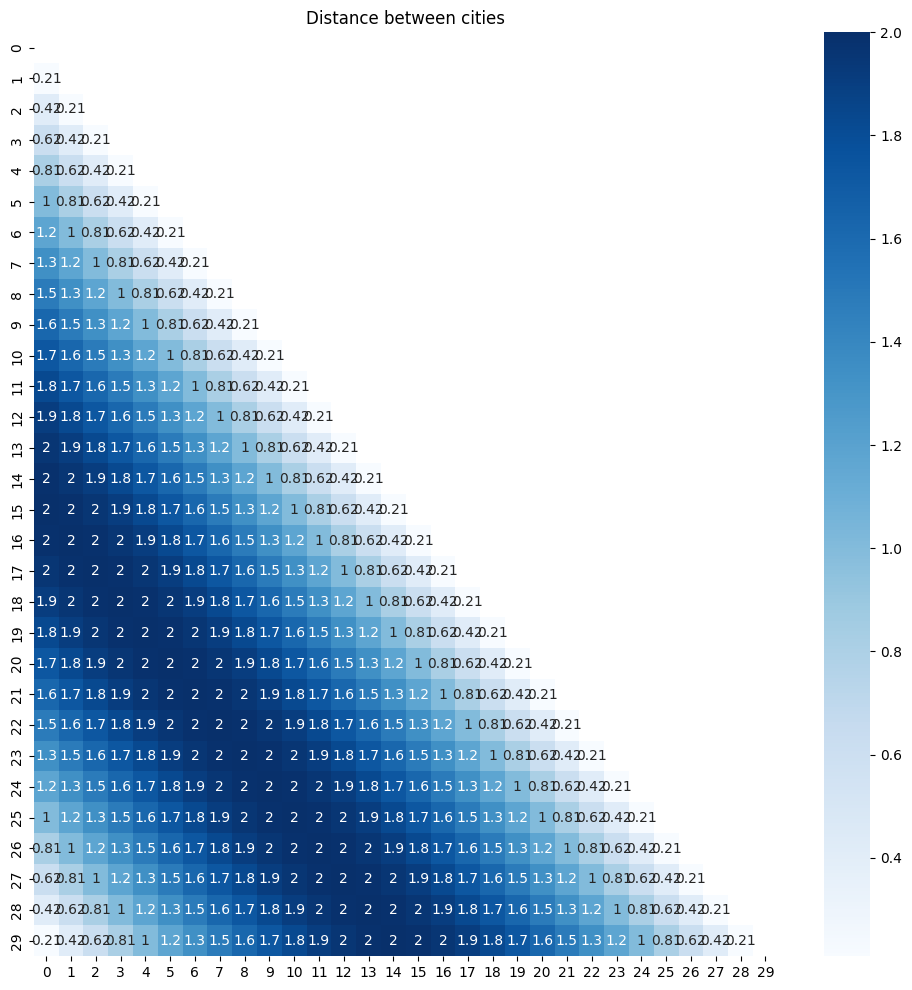

In [4]:
distances: np.ndarray = np.array([[get_distance_between_cities(cities[i], cities[j]) for j in range(CITIES)] for i in range(CITIES)])

# plot the distance between cities (using heatmap)
plt.figure(figsize=(12, 12))
mask = np.zeros_like(distances)  # create a mask
mask[np.triu_indices_from(mask)] = True  # apply the mask
sns.heatmap(distances, annot=True, mask=mask, cmap='Blues')  # plot heatmap
plt.title('Distance between cities')
plt.show()

In this heatmap we can see the distance between each city.

### [Exhaustive Search](https://en.wikipedia.org/wiki/Exhaustive_search)

We implement a program that generates all possible solutions for the TSP using two algorithms, namely the **Heap algorithm** and the **Steinhaus–Johnson–Trotter algorithm**. By examining the complete solution space, we aim to evaluate the computational feasibility of exhaustively solving TSP for a given number of cities.

- Time Complexity: $O(n!)$
- Space Complexity: $O(n)$

New best solution found: (0, 1, 2, 3, 4, 5, 6, 8, 9, 7) with fitness 3.9560224799517445
New best solution found: (0, 1, 2, 3, 4, 5, 6, 9, 8, 7) with fitness 3.9127608358016874
New best solution found: (0, 1, 2, 3, 4, 5, 7, 6, 8, 9) with fitness 3.600175087831056
New best solution found: (0, 1, 2, 3, 4, 5, 7, 6, 9, 8) with fitness 3.5596043615796895
New best solution found: (0, 1, 2, 3, 4, 5, 7, 8, 9, 6) with fitness 3.198400572466973
New best solution found: (0, 1, 2, 3, 4, 7, 5, 8, 9, 6) with fitness 3.193245664227754
New best solution found: (0, 1, 2, 3, 5, 7, 4, 8, 9, 6) with fitness 2.981080806304276
New best solution found: (0, 1, 2, 3, 7, 5, 4, 8, 9, 6) with fitness 2.9686711291408336
New best solution found: (0, 1, 2, 4, 5, 7, 3, 8, 9, 6) with fitness 2.8233363332032733
New best solution found: (0, 1, 2, 6, 9, 8, 3, 4, 5, 7) with fitness 2.8125738864391634
New best solution found: (0, 1, 4, 2, 6, 8, 9, 3, 5, 7) with fitness 2.6958167652282214
New best solution found: (0, 1, 4, 2

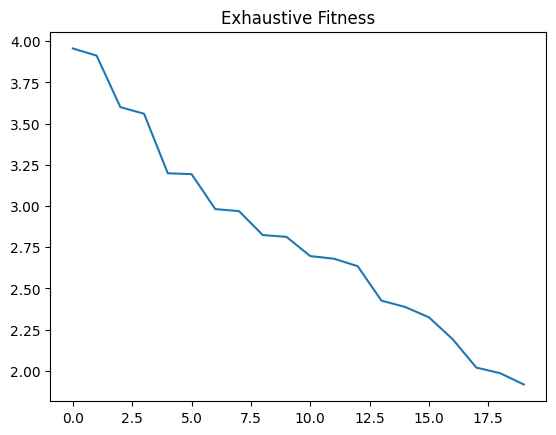

In [5]:
def exhaustive_search(cities: np.ndarray) -> tuple[np.ndarray, list[float]]:
    """Exhaustive search algorithm."""
    best_solution: np.ndarray = np.random.permutation(len(cities))  # initialize a random solution
    best_fitness = get_fitness(cities, best_solution)  # initialize best fitness (total distance)
    fitnesses = []  # list that will contain all fitnesses (for plotting)

    for solution in itertools.permutations(np.arange(len(cities))):
        fitness = get_fitness(cities, solution)
        if fitness < best_fitness:  # if new best solution is found
            fitnesses.append(fitness)
            print(f"New best solution found: {solution} with fitness \033[92m{fitness}\033[0m")
            best_fitness = fitness  # update best fitness
            best_solution = solution  # type: ignore # update best solution
    return (best_solution, fitnesses)  # return best solution



#! this next 4 lines are commented out because they take a long time to run...
# just for the sake of the example, I will use ONLY (is not a good idea) 10 cities
t_cities = generate_cities(10)  # random pos to 
exhaustive_solution = exhaustive_search(t_cities)  # run exhaustive search
plot_fitness("Exhaustive Fitness", exhaustive_solution[1])  # plot fitness

Solution:  (6, 0, 2, 1, 4, 8, 9, 3, 5, 7)
Distance: 1.9164847841303074
7 -> 6: 0.14281203412684348
6 -> 0: 0.3694911433035603
0 -> 2: 0.21461760700246868
2 -> 1: 0.12239474280934093
1 -> 4: 0.29385714237400024
4 -> 8: 0.062143715672950774
8 -> 9: 0.20066519862379434
9 -> 3: 0.34131317592530813
3 -> 5: 0.16919002429204044


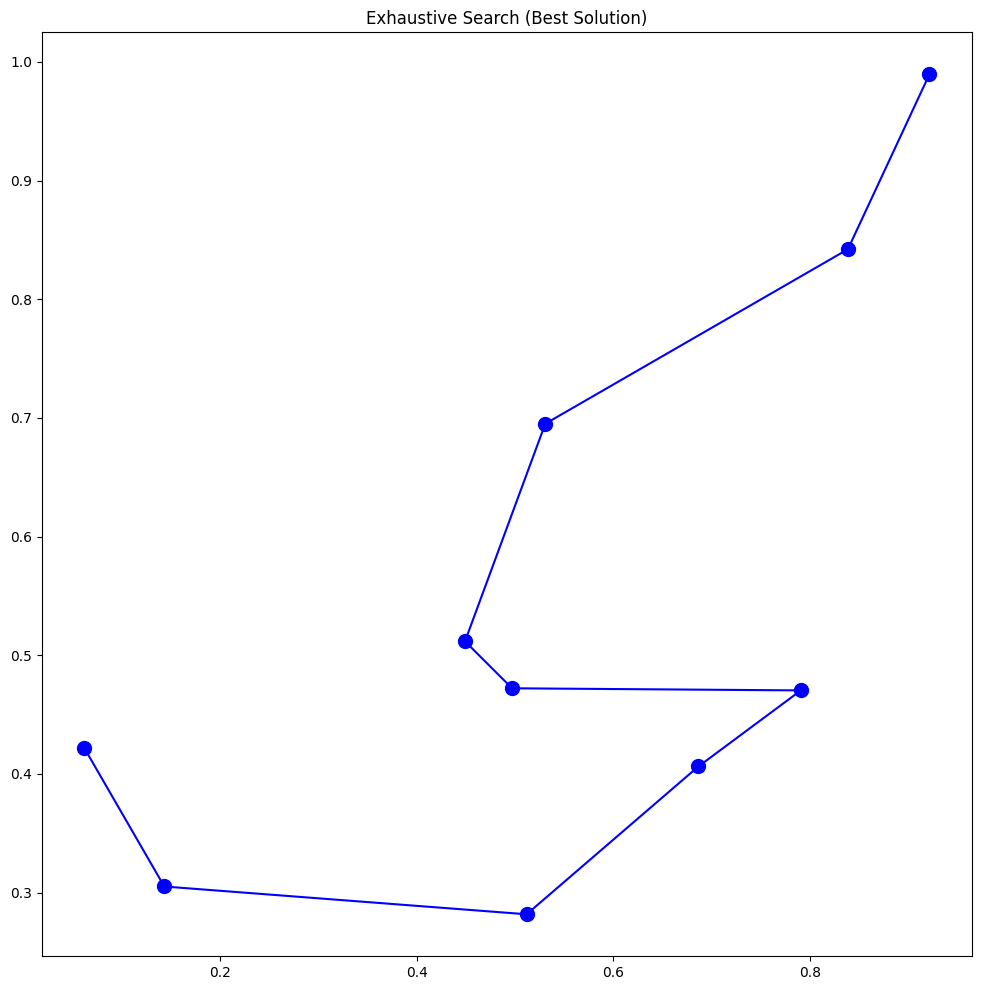

In [6]:
print_distances(t_cities, exhaustive_solution[0])  # print distances
plot_solution("Exhaustive Search (Best Solution)", t_cities, exhaustive_solution[0])  # plot solution

Using the **Exhaustive Search** we can find the optimal solution for the TSP problem, but the time complexity is $O(n!)$, so **it's not feasible for a large number of cities**.

#### [Heap's Algorithm](https://en.wikipedia.org/wiki/Heap%27s_algorithm)

The Heap's Algorithm constructs all possible permutations of $n$ objects. It is a **[recursive](https://en.wikipedia.org/wiki/Recursion_(computer_science))** algorithm that generates each permutation from the previous one by choosing two elements to interchange.

The algorithm generates each permutation from the previous one by choosing two elements to interchange. The number of permutations of $n$ objects is $n!$.

The algorithm is named after [B. R. Heap](https://en.wikipedia.org/wiki/B._R._Heap), who published it in 1963, but it was first proposed by [Johnson](https://en.wikipedia.org/wiki/Johnson%27s_algorithm) in 1962.

Fitness of permutation 0: 6.062650869523903
Fitness of permutation 1: 5.853593942988597
Fitness of permutation 2: 6.062650869523903
Fitness of permutation 3: 5.853593942988597
Fitness of permutation 4: 6.062650869523903
Fitness of permutation 5: 5.853593942988597
Fitness of permutation 6: 6.269417324624115
Fitness of permutation 7: 5.853593942988597
Fitness of permutation 8: 6.062650869523903
Fitness of permutation 9: 5.853593942988597
Fitness of permutation 10: 6.062650869523903
Fitness of permutation 11: 5.853593942988597
Fitness of permutation 12: 6.062650869523903
Fitness of permutation 13: 5.853593942988597
Fitness of permutation 14: 6.062650869523903
Fitness of permutation 15: 5.853593942988597
Fitness of permutation 16: 6.062650869523903
Fitness of permutation 17: 5.853593942988597
Fitness of permutation 18: 5.64453701645329
Fitness of permutation 19: 5.435480089917982
Fitness of permutation 20: 5.435480089917982
Fitness of permutation 21: 5.435480089917982
Fitness of permutatio

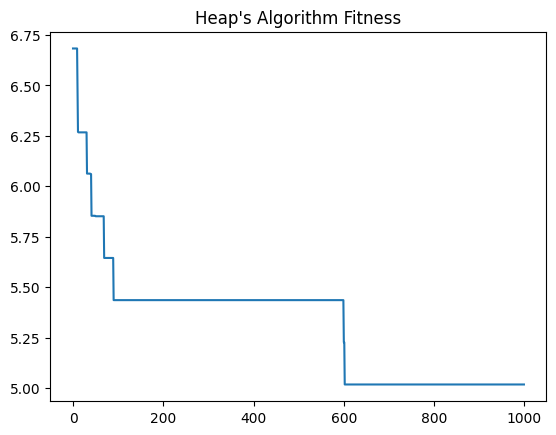

In [7]:
def heaps_algorithm(cities: np.ndarray, size: int, generations: int = 1000) -> tuple[np.ndarray, list[float]]:
    permutations = []  # List to store permutations
    fitnesses = []  # List to store fitness values

    # Auxiliary function to generate all permutations of a list
    def generate_permutations(cities: np.ndarray, n: int) -> None:
        nonlocal permutations, fitnesses  # nonlocal variables (to be able to modify them)

        if n != 1:  # If size is not 1, then generate all permutations of size n-1
            for i in range(n):  # One by one move all characters from the first to the last
                generate_permutations(cities, n - 1)  # Call itself recursively to generate permutations
                if n % 2 == 0:  # If n is even, swap the i-th and the last element
                    cities[i], cities[n - 1] = cities[n - 1], cities[i]
                else:  # If n is odd, swap the first and the last element
                    cities[0], cities[n - 1] = cities[n - 1], cities[0]
                if len(permutations) >= generations:  # Check if the maximum number of generations is reached
                    return  # If so, return
        else:  # If size is 1, then append the obtained permutation
            permutations.append(cities.copy())  # If size is 1, then append the obtained permutation

    generate_permutations(cities.copy(), size)  # Generate all permutations of cities

    for i in range(len(permutations)):  # Calculate the fitness of each permutation
        fitnesses.append(sum([get_distance_between_cities(permutations[i][j], permutations[i][j + 1]) for j in range(len(permutations[i]) - 1)]))
        print(f"Fitness of permutation {i}: {fitnesses[i]}")  # Print fitness of each permutation

    return permutations[fitnesses.index(min(fitnesses))], fitnesses  # Return the best solution and all fitnesses

heaps_solution: tuple[np.ndarray, list[float]] = heaps_algorithm(cities.copy(), len(np.arange(CITIES)))
plot_fitness("Heap's Algorithm Fitness", sorted(heaps_solution[1], reverse=True))  # plot fitness

As we can see, in the Fitness function, the fitness only makes it lower only wen some iteration is better than the previous one.

City 0: [0.5       0.8660254]
City 1: [0.5       0.8660254]
City 2: [0.5       0.8660254]
City 3: [0.5       0.8660254]
City 4: [0.5       0.8660254]
City 5: [0.5       0.8660254]
City 6: [0.30901699 0.95105652]
City 7: [0.10452846 0.9945219 ]
City 8: [-0.10452846  0.9945219 ]
City 9: [-0.30901699  0.95105652]
City 10: [-0.5        0.8660254]
City 11: [-0.66913061  0.74314483]
City 12: [-0.80901699  0.58778525]
City 13: [-0.91354546  0.40673664]
City 14: [-0.9781476   0.20791169]
City 15: [-1.0000000e+00  5.6655389e-16]
City 16: [-0.9781476  -0.20791169]
City 17: [-0.91354546 -0.40673664]
City 18: [-0.80901699 -0.58778525]
City 19: [-0.66913061 -0.74314483]
City 20: [-0.5       -0.8660254]
City 21: [-0.30901699 -0.95105652]
City 22: [-0.10452846 -0.9945219 ]
City 23: [ 0.10452846 -0.9945219 ]
City 24: [ 0.30901699 -0.95105652]
City 25: [ 0.5       -0.8660254]
City 26: [ 0.66913061 -0.74314483]
City 27: [ 0.80901699 -0.58778525]
City 28: [ 0.91354546 -0.40673664]
City 29: [ 0.9781476  -

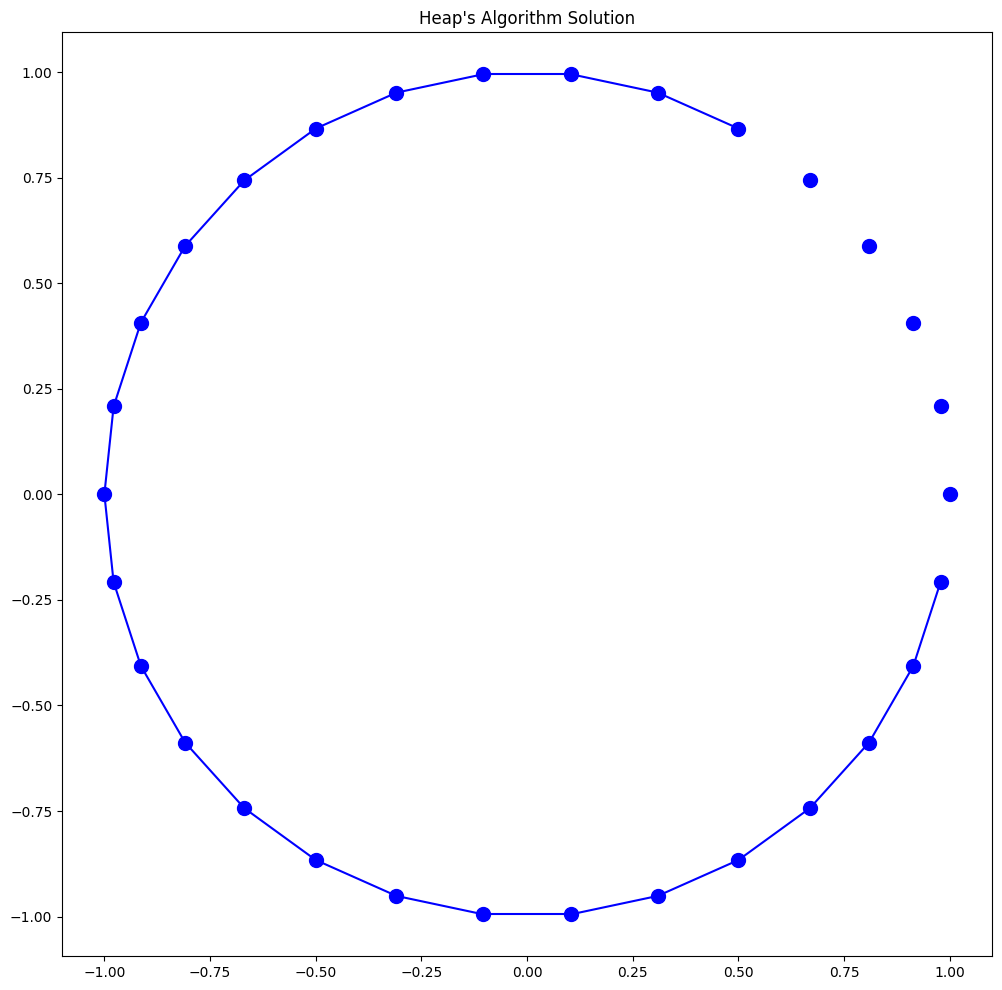

In [37]:
# print_distances(cities, heap_solution)
plt.figure(figsize=(12, 12))
plt.scatter(cities[:, 0], cities[:, 1], c='blue', s=100)  # draw the cities


cities_route = heaps_solution[0]

# make thisa loop to print all the cities
for i in range(len(heaps_solution[0])):
    print(f"City {i}: {cities_route[i]}")

# plot a line between cirty 1 and city 2
for i in range(len(heaps_solution[0])-1):
    plt.plot([cities_route[i][0], cities_route[i+1][0]], [cities_route[i][1], cities_route[i+1][1]], c='blue')

# 

plt.title("Heap's Algorithm Solution")
plt.show()

#### [SJT Algorithm](https://en.wikipedia.org/wiki/Steinhaus%E2%80%93Johnson%E2%80%93Trotter_algorithm)

The Steinhaus-Johnson-Trotter (SJT) algorithm is a **[recursive](https://en.wikipedia.org/wiki/Recursion_(computer_science))** algorithm that generates each permutation from the previous one by choosing two elements to interchange.

The algorithm generates each permutation from the previous one by choosing two elements to interchange. The number of permutations of $n$ objects is $n!$.

The algorithm is named after [Hugo Steinhaus](https://en.wikipedia.org/wiki/Hugo_Steinhaus), [Selmer M. Johnson](https://en.wikipedia.org/wiki/Selmer_M._Johnson), and [Hale F. Trotter](https://en.wikipedia.org/wiki/Hale_F._Trotter), who published it in 1963, but it was first proposed by [Johnson](https://en.wikipedia.org/wiki/Johnson%27s_algorithm) in 1962.

  0: [30 29 28 27 26 25 24 23 11 12 19  3  6 22 14  7 15 13  4 17 21  1  9  2
 18 20 10  8  5 16] -> 30.1779
  1: [11 12 19 24  3 28  6 14 26 27  7 15 22 13  4 17 30 21  1 23  9  2 18 25
 20 29 10  8  5 16] -> 40.7514
  2: [11 12 19 24  3 28  6 14 26 27  7 15 22 13  4 30 17 21  1 23  9  2 18 25
 20 29 10  8  5 16] -> 38.8040
  3: [11 12 19 24  3 28  6 14 26 27  7 15 22 13 30  4 17 21  1 23  9  2 18 25
 20 29 10  8  5 16] -> 39.1423
  4: [11 12 19 24  3 28  6 14 26 27  7 15 22 30 13  4 17 21  1 23  9  2 18 25
 20 29 10  8  5 16] -> 39.8151
  5: [11 12 19 24  3 28  6 14 26 27  7 15 30 22 13  4 17 21  1 23  9  2 18 25
 20 29 10  8  5 16] -> 40.1386
  6: [11 12 19 24  3 28  6 14 26 27  7 30 15 22 13  4 17 21  1 23  9  2 18 25
 20 29 10  8  5 16] -> 39.8425
  7: [11 12 19 24  3 28  6 14 26 27 30  7 15 22 13  4 17 21  1 23  9  2 18 25
 20 29 10  8  5 16] -> 38.2148
  8: [11 12 19 24  3 28  6 14 26 30 27  7 15 22 13  4 17 21  1 23  9  2 18 25
 20 29 10  8  5 16] -> 39.2130
  9: [11 12 19 24  

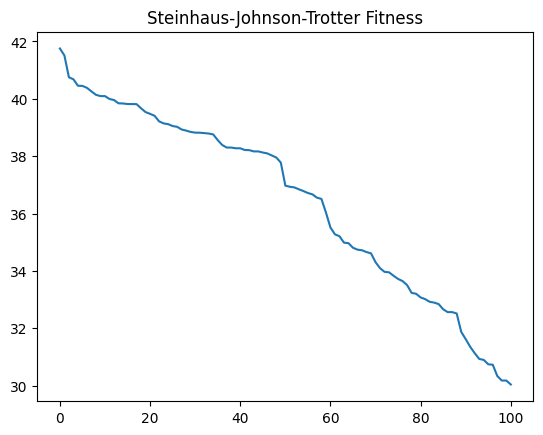

In [9]:
factorial = lambda n: 1 if n == 0 else n * factorial(n - 1)  # factorial function

def _get_mobile(a: list[int], dir: list[bool], n: int) -> int:
	"""Get Mobile Integer from the given array a[] and direction dir[] which shows whether dir[i] is LEFT TO RIGHT or RIGHT TO LEFT."""
	mobile_prev: int = 0  # previous mobile integer in the array
	mobile: int = 0  # mobile integer
	for i in range(n):  # find the largest mobile integer
		if dir[a[i] - 1] == False and i != 0:  # direction 0 represents RIGHT TO LEFT.
			if a[i] > a[i - 1] and a[i] > mobile_prev:  
				mobile = a[i]
				mobile_prev = mobile
		if dir[a[i] - 1] == True and i != n - 1:  # direction 1 represents LEFT TO RIGHT.
			if a[i] > a[i + 1] and a[i] > mobile_prev:
				mobile = a[i]
				mobile_prev = mobile
	if mobile == 0 and mobile_prev == 0:  # if no mobile integer is found
		return 0  # return 0 (i.e. no largest mobile integer)
	else: return mobile  # return found mobile integer


fitnesses = []  # list to store the fitness values of the permutations
permutations = []  # List to store permutations

def _get_permutation(a: list[int], dir: list[bool], n: int):
	"""
	To generate the next permutation using the given permutation
	
	### Parameters:
	- `a`: list of integers
	- `dir`: list of boolean values
	- `n`: size of list `a`
	"""
	mobile = _get_mobile(a, dir, n)
	pos: int = [i + 1 for i in range(n) if a[i] == mobile][0]

	# swapping the elements according to the direction i.e. dir[]
	if dir[a[pos - 1] - 1] == False: a[pos - 1], a[pos - 2] = a[pos - 2], a[pos - 1]  # direction 0 represents RIGHT TO LEFT.
	elif dir[a[pos - 1] - 1] == True: a[pos], a[pos - 1] = a[pos - 1], a[pos]  # direction 1 represents LEFT TO RIGHT.
	for i in range(n):  # changing the directions for elements greater than largest mobile integer
		if a[i] > mobile:  # if element is greater than largest mobile integer
			if dir[a[i] - 1] == True: dir[a[i] - 1] = False  # direction 1 means ->
			elif dir[a[i] - 1] == False: dir[a[i] - 1] = True  # direction 0 means <-
	permutations.append(a.copy())  # store the permutation
	# return a.copy()  # return the next permutation


def sjt_algorithm(cities: np.ndarray, generations: int = 100) -> None:
	"""
	To generate all permutations of n integers using Steinhaus-Johnson-Trotter algorithm.

	### Parameters:
	- `n`: size of list `a`
	"""
	n = len(cities)
	permutations.append(np.random.permutation([i + 1 for i in range(n)]))  # store the permutation
	# for _ in range(factorial(n) - 1):  # generate all permutations
	for _ in range(generations):  # generate as many permutations as generations (iteration limit)
		_get_permutation(permutations[0], [False for _ in range(n)], n)  # generate the next permutation
	for i in range(len(permutations)):  # calculate the fitness values of all permutations
		fitnesses.append(sum([get_distance_between_cities(cities[permutations[i][j] - 1], cities[permutations[i][j + 1] - 1]) for j in range(len(cities) - 1)]))
	[print(f"{i:3}: {permutations[i]} -> \033[92m{fitnesses[i]:.4f}\033[0m") for i in range(len(permutations))]  # print the permutations and their fitness values

sjt_algorithm(cities)

# sort fitnesses and plot
plot_fitness("Steinhaus-Johnson-Trotter Fitness", sorted(fitnesses, reverse=True))

sjt_solution = permutations[np.argmax(fitnesses)]

For every exhaustive method we can see that the fitness is always decreasing, because we are always looking for a better solution than the previous one.

Total Distance: 41.75393130687798


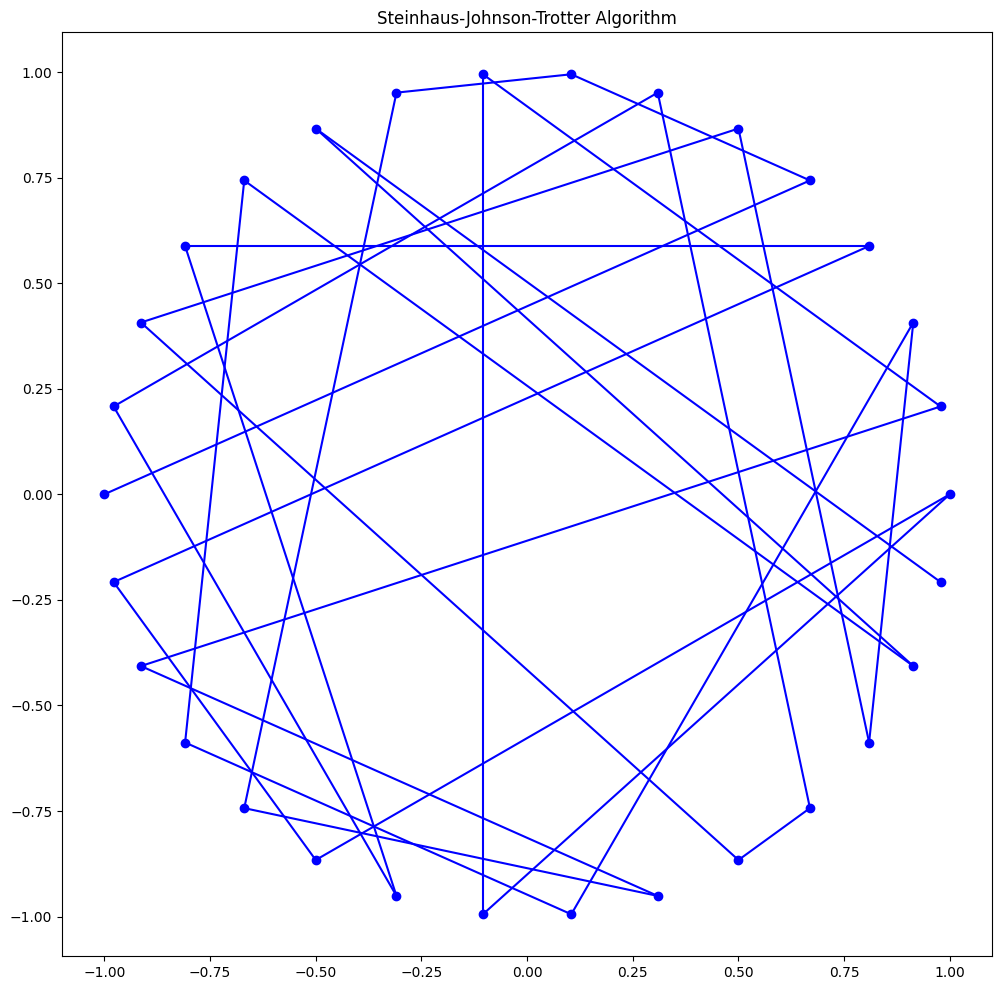

In [49]:
# print_distances(cities, random_solution[0])
plt.figure(figsize=(12, 12))
plt.title("Steinhaus-Johnson-Trotter Algorithm")
print(f"Total Distance: \033[92m{sum([get_distance_between_cities(cities[sjt_solution[i] - 1], cities[sjt_solution[i + 1] - 1]) for i in range(len(cities) - 1)])}\033[0m")
[plt.plot([cities[sjt_solution[i] - 1][0], cities[sjt_solution[i + 1] - 1][0]], [cities[sjt_solution[i] - 1][1], cities[sjt_solution[i + 1] - 1][1]], c="b") for i in range(len(cities) - 1)]
plt.scatter(cities[:, 0], cities[:, 1], c="b")
plt.show()

The found solution is the bette that we get of all the iterations, but as we can see is not a good one.


### [Random Search](https://en.wikipedia.org/wiki/Random_search)

Random Search is a simple **[stochastic](https://en.wikipedia.org/wiki/Stochastic)** optimization algorithm that does not use any information about the problem to find the solution. It is a **[Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method)** method that randomly samples the search space to find the solution.

New best solution found: [25  5  7 15 18 10  0  4 27 28 26 13  2  9 11 24  1 12  6 22  3 20 16  8
 29 21 23 17 14 19] with fitness 36.4677859989052
New best solution found: [27 21  7 14 10  8  5  6  2 17 16  3 12 11 25  0 22  1 24 19 13 28 20 23
 26 18 15 29  4  9] with fitness 33.78810362719095
New best solution found: [13 10  8 29 25 22 19 11 12  9  7 27 18 16  2 23  6 28  0  4 15  5 26  1
 20 17 24 21  3 14] with fitness 33.78330381329465
New best solution found: [21 22 25  7 14 15  0 29 28 18 13 27  3 16 11 12  2 17  9  8  6 19 23 20
  4  5  1 26 10 24] with fitness 32.97733799905258
New best solution found: [20 18 16 14 10 21 26 11 23 17 19 24 22  5  7  3 29 12 13 28 15 27  6  9
  8  4  1  0  2 25] with fitness 29.659963864081945
New best solution found: [15 19 17  4  5 10  8  0 28 23  6 25 27 29 14  7 21 16 13 11 12  9 20 26
 22  2  1  3 24 18] with fitness 29.482541694260888
New best solution found: [ 7 11 21 20 23 24  2 29  3 18 17  1 10 12 13 14  4  5  6  9 25 22 26 28
 19 27 

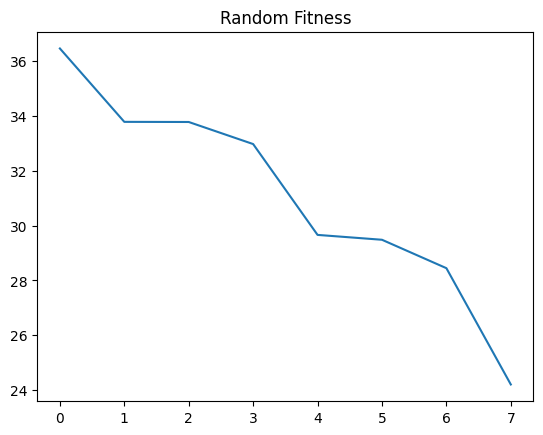

In [11]:
def random_search(cities: np.ndarray, iterations: int = 100) -> tuple[np.ndarray, list[float]]:
    """
    Random Search Algorithm is a simple one. Just generate a random solution and check if it is better than the best solution found so far.
    If it is, then update the best solution. Repeat this process for a given number of iterations.

    ### Parameters:
        cities: np.ndarray - The cities to visit.
        iterations: int - The number of iterations to run the algorithm for.

    ### Returns:
        np.ndarray - The best solution found.
    """
    best_fitness = np.inf
    best_solution = np.arange(CITIES)

    all_fitnesses = []  # list to store all fitnesses
    for _ in range(iterations):  # for each iteration
        solution = np.random.permutation(CITIES)
        fitness = np.sum([get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(CITIES - 1)])
        if fitness < best_fitness:
            all_fitnesses.append(fitness)  # add fitness to list
            print(f"New best solution found: {solution} with fitness \033[92m{fitness}\033[0m")
            best_fitness = fitness
            best_solution = solution  # update best solution
    return (best_solution, all_fitnesses)  # return best solution

random_solution = random_search(cities, iterations=GENERATIONS*20)  # just run for 10 iterations (for the sake of time)
plot_fitness("Random Fitness", random_solution[1])  # plot the fitnesses

The fitness on a random search only makes it lower only when some iteration is better than the previous one.
In this case I've only store the iterations that are better than the previous one. So **in the 100 iterations**, we **only record 7** iterations and the best one is the last one, but **compared with an optimal solution** (described in the next section) **is not really good in terms of fitness**.

Travelled distance: 24.19776863665676


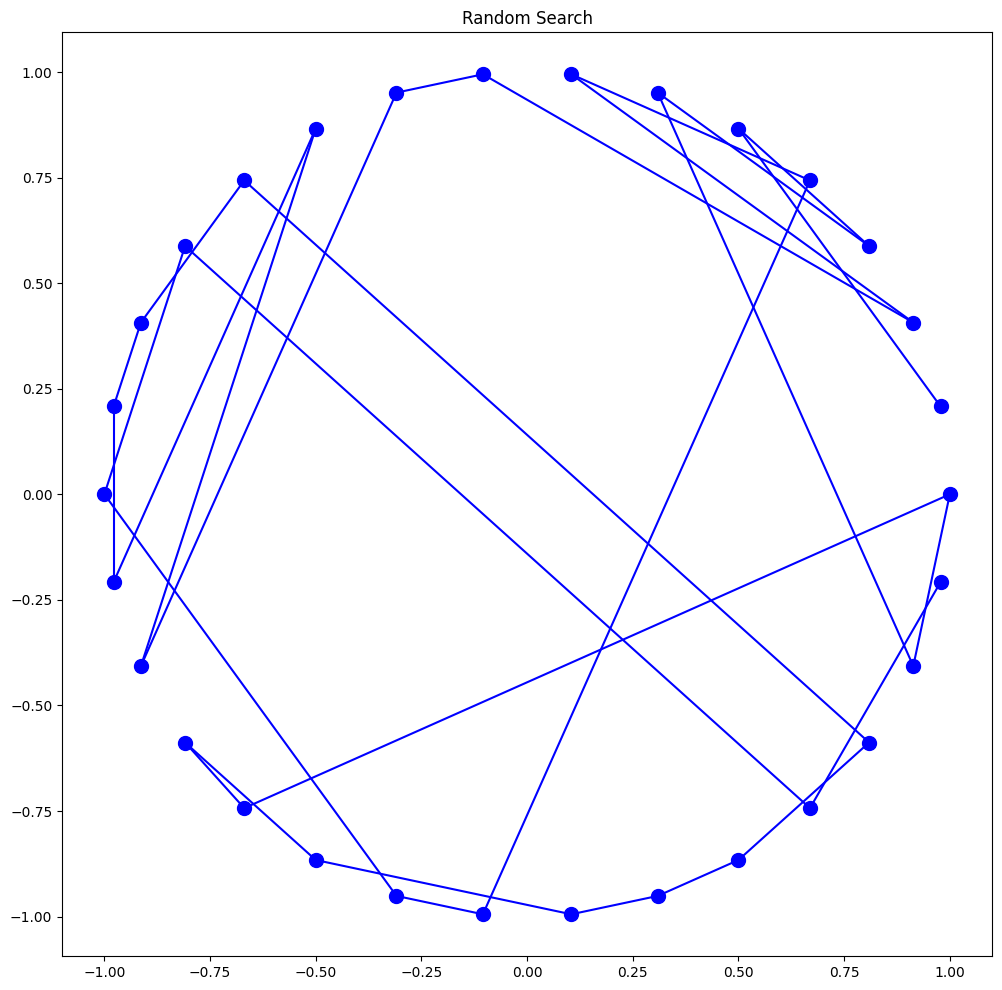

In [12]:
# print_distances(cities, random_solution[0])
print(f"Travelled distance: \033[92m{sum([get_distance_between_cities(cities[random_solution[0][i]], cities[random_solution[0][i + 1]]) for i in range(len(cities) - 1)])}\033[0m")
plot_solution("Random Search", cities, random_solution[0])

As we can see, the **random search is not a good algorithm to solve the TSP problem**, because it's not able to find a good solution. It probably finds a good solution only by chance, but it's not able to find it again.

### [Hill Climbing Search](https://www.geeksforgeeks.org/introduction-hill-climbing-artificial-intelligence/)

Is a heuristic search used for mathematical optimization problems in the field of Artificial Intelligence.

Given a large set of inputs and a good heuristic function, it tries to find a sufficiently good solution to the problem. This solution may not be the global optimal maximum.

**Steps:**

2. At each iteration, the algorithm selects a pair of edges and checks if swapping them leads to a shorter total distance.
3. If a shorter distance is found, the swap is performed, and the process continues with the modified solution.
4. This process is repeated until no further improvement is possible, and a local optimum is reached.

In [46]:
n_cities = 50
# cities = np.array([[np.cos(2 * np.pi * i / n_cities), np.sin(2 * np.pi * i / n_cities)] for i in range(n_cities)])
# city_list = generate_cities(50)  # generate cities

distance_calculation = lambda r, c: np.sum([np.linalg.norm(c[r[i]] - c[r[i - 1]]) for i in range(len(r))])
# where r is the route and c is the city list

swap_algorithm = lambda r, i, k: np.concatenate((r[0:i], r[k:i - 1:-1], r[k + 1:len(r)]))
# where r is the route, i is the first city to swap and k is the second city to swap

# random_solution = np.random.permutation(len(cities))  # generate random solution
print(f"RANDOM SOLUTION DISTANCE: \033[92m{sum([get_distance_between_cities(cities[random_solution[0][i]], cities[random_solution[0][i + 1]]) for i in range(len(cities) - 1)])}\033[0m")
# plot_solution("Random Search", cities, random_solution[0])  # is the same figure as the one above

RANDOM SOLUTION DISTANCE: 24.19776863665676


To test the next algorithms, we'll use the solution given by the **random search** algorithm. (just to make the test different from the previous one even if the result is the same).

#### Hill Climbing 2 Opt

1. It's performed by **considering pairs of edges** in the current solution.

In [14]:
def hill_climbing_2_opt(solution, city_list):
    """
    Hill Climbing - 2 Opt Algorithm makes small changes to the solution and checks if the new solution is better than the old solution.
    """
    current_best_distance = distance_calculation(solution, city_list)  # calculate the distance
    for swap_1 in range(1, len(solution) - 2):  # for each city except the first and last
        for swap_2 in range(swap_1 + 1, len(solution) - 1):  # for each city except the last
            new_solution = swap_algorithm(solution, swap_1, swap_2)  # swap the cities
            new_distance = distance_calculation(new_solution, city_list)  # calculate the distance
            if new_distance < current_best_distance:  # if the new distance is better than the old distance
                solution = new_solution  # update the solution
                current_best_distance = new_distance  # update the distance
                # print('new best distance: ', current_best_distance)
    return np.array(solution)

Travelled distance: 8.705380342918827


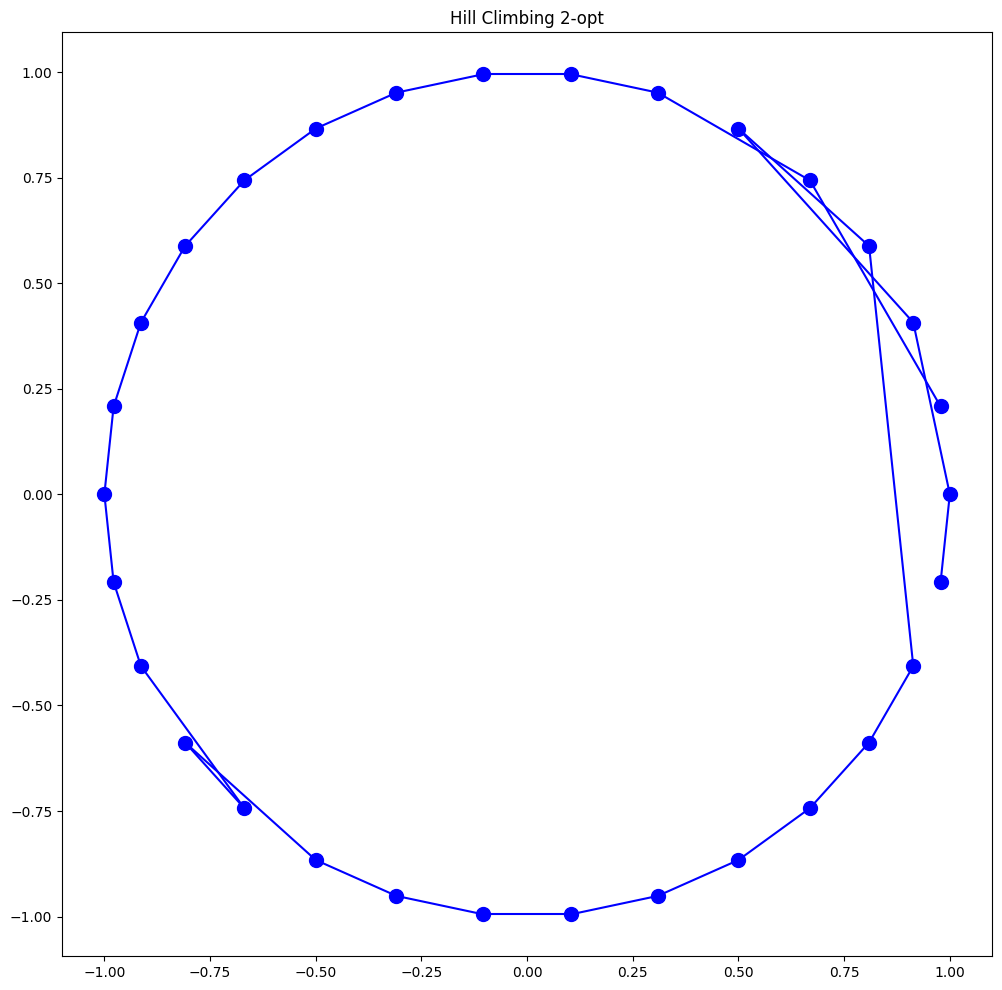

In [40]:
hill_climbing_2_solution = random_solution[0].copy()  # copy the solution
hill_climbing_2_solution = hill_climbing_2_opt(hill_climbing_2_solution, cities)  # run the algorithm

# print_distances(city_list, hill_climbing_2_solution)  # print the distances
print(f"Travelled distance: \033[92m{sum([get_distance_between_cities(cities[hill_climbing_2_solution[i]], cities[hill_climbing_2_solution[i + 1]]) for i in range(len(cities) - 1)])}\033[0m")  # print the distance
plot_solution("Hill Climbing 2-opt", cities, hill_climbing_2_solution)  # plot the solution

The **HC 2Opt algorithm is blazingly fast**, but **it's not guaranteed to find an optimal solution**. It's a **[greedy](https://en.wikipedia.org/wiki/Greedy_algorithm)** algorithm that **only considers the immediate neighbors of the current solution**.

So it's a **local search algorithm** that **does not consider the complete solution space**.

Running the algorithm multiple times with different starting solutions can help us find a better solution, some times the given solution is even better than the [HC 3Opt](#hill-climbing-3-opt) algorithm.

#### Hill Climbing 3 Opt

1. The Opt3 algorithm expands on the Opt2 algorithm by considering triplets of edges in the current solution.

In [16]:
def hill_climbing_3_opt(solution, city_list):
    """
    Hill Climbing - 3 Opt Algorithm makes small changes to the solution and checks if the new solution is better than the old solution.
    """
    current_best_distance = distance_calculation(solution, city_list)
    for swap_1 in range(1, len(solution) - 3):
        for swap_2 in range(swap_1 + 1, len(solution) - 2):
            for swap_3 in range(swap_2 + 1, len(solution) - 1):
                new_solution = swap_algorithm(solution, swap_1, swap_3)
                new_distance = distance_calculation(new_solution, city_list)
                if new_distance < current_best_distance:
                    solution = new_solution
                    current_best_distance = new_distance
                    # print('new best distance: ', current_best_distance)
    return np.array(solution)

Travelled distance: 7.087371449053289


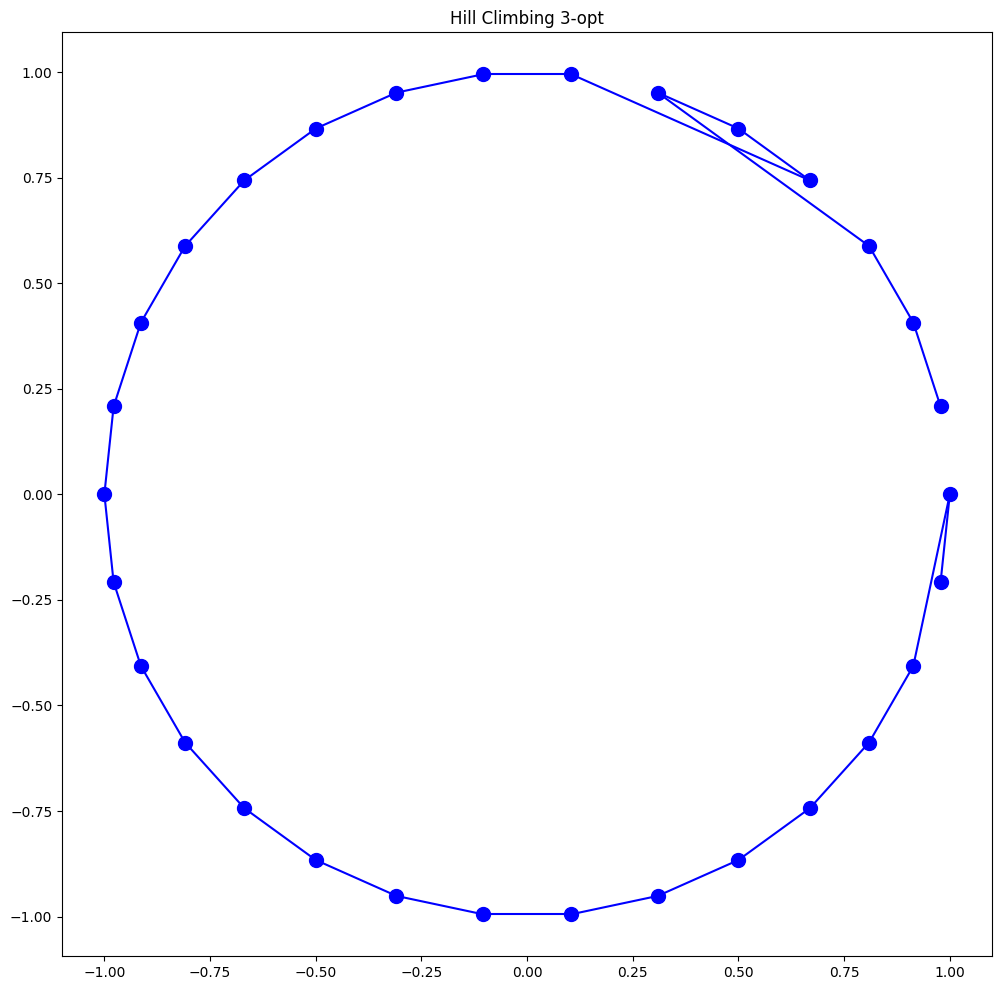

In [41]:
hill_climbing_3_solution = random_solution[0].copy()  # copy the solution
hill_climbing_3_solution = hill_climbing_3_opt(hill_climbing_3_solution, cities)  # run the algorithm

# print_distances(city_list, hill_climbing_3_solution)  # print the distances
print(f"Travelled distance: \033[92m{sum([get_distance_between_cities(cities[hill_climbing_3_solution[i]], cities[hill_climbing_3_solution[i + 1]]) for i in range(len(cities) - 1)])}\033[0m")  # print the distance
plot_solution("Hill Climbing 3-opt", cities, hill_climbing_3_solution)  # plot the solution

By iterating many times the HC 3Opt algorithm we can find a good solution for the TSP problem.
**The solution is not the best one but is a good one**. The algorithm also **is very fast** and the given solution will be different depending on the initial solution, so **we can run the algorithm many times to find the best solution**.

The time complexity is $O(n^3)$, so it's feasible for a large number of cities.